In [1]:
from typing import List, NamedTuple, Tuple, Union, Dict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from msi_zarr_analysis.ml.dataset.cytomine_ms_overlay import get_overlay_annotations
from msi_zarr_analysis.ml.dataset.translate_annotation import (
    TemplateTransform,
    match_template_ms_overlay,
    rasterize_annotation_mapping,
    translate_parsed_annotation_mapping,
)
from msi_zarr_analysis.utils.check import open_group_ro
from msi_zarr_analysis.utils.cytomine_utils import get_page_bin_indices

from scripts.connect_from_json import connect


class DSConfig(NamedTuple):
    image_id_overlay: int  # Cytomine ID for the overlay image
    local_overlay_path: str  # local path of the (downloaded) overlay
    lipid_tm: str  # name of the lipid to base the template matching on

    project_id: int  # project id
    annotated_image_id: int  # image with the annotations

    classes: Dict[str, List[int]]

    save_image: Union[bool, str] = False

    transform_rot90: int = 0
    transform_flip_ud: bool = False
    transform_flip_lr: bool = False

    annotation_users_id: Tuple[int] = ()  # select these users only

    zarr_template_path: str = None  # use another group for the template matching

In [2]:
config = DSConfig(
    **{
        "image_id_overlay": 545025763,
        "local_overlay_path": "../datasets/Adjusted_Cytomine_MSI_3103_Region013-Viridis-stacked.ome.tif",
        "lipid_tm": "LysoPPC",
        "project_id": 542576374,
        "annotated_image_id": 545025783,
        "transform_rot90": 1,
        "transform_flip_ud": True,
        "transform_flip_lr": False,
        "annotation_users_id": (),
        "zarr_template_path": "../datasets/comulis13_binned.zarr",
    },
    classes={  # both merged
        #"+": [544926081, 544924846],
        #"-": [544926097, 544926052],
        "LS": [544926097, 544926081],
        "SC": [544926052, 544924846],
    },
)

template_transform = TemplateTransform(
    rotate_90=config.transform_rot90,
    flip_lr=config.transform_flip_lr,
    flip_ud=config.transform_flip_ud,
)

lipid = "LysoPPC"
lipid_df_path = "../mz value + lipid name.csv"

group_binned = open_group_ro(config.zarr_template_path)

In [3]:
connect("../config_cytomine.json")

# template matching...
page_idx, bin_idx, *_ = get_page_bin_indices(
    image_id=config.image_id_overlay, lipid=lipid, csv_lipid_mz_path=lipid_df_path
)

annotation_dict = get_overlay_annotations(
    project_id=config.project_id,
    image_id=config.image_id_overlay,
    classes=config.classes,
    select_users=config.annotation_users_id,
)

[2022-09-21 15:42:56,678][INFO] [GET] [currentuser] CURRENT USER - 534530561 : mamodei | 200 OK
[2022-09-21 15:42:57,136][INFO] [GET] [sliceinstance collection] 12 objects | 200 OK
[2022-09-21 15:42:57,646][INFO] [GET] [annotation collection] 396 objects | 200 OK
[2022-09-21 15:42:57,771][INFO] [GET] [imageinstance] 545025763 : Adjusted Cytomine MSI 3103/Region013-Viridis-stacked.ome.tif | 200 OK
[2022-09-21 15:42:57,947][INFO] [GET] [term collection] 35 objects | 200 OK


In [4]:
matching_result, crop_idx = match_template_ms_overlay(
    group_binned,
    bin_idx,
    config.local_overlay_path,
    page_idx,
    template_transform,
)

In [5]:
annotation_dict = translate_parsed_annotation_mapping(
    annotation_dict,
    template_transform,
    matching_result,
    crop_idx,
)

In [15]:
# get base image
img = group_binned["/0"][bin_idx, 0]

In [16]:
# rasterize annotations
full_shape = img.shape
raster_dict = rasterize_annotation_mapping(
    annotation_dict,
    full_shape,
)

In [17]:
# preprocess img
img = template_transform.transform_template(img)
img[img == 0] = np.nan

LS: tab:green
SC: tab:red


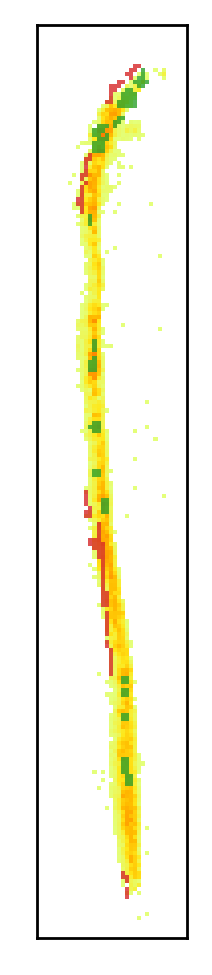

In [18]:
fig, ax = plt.subplots(dpi=250)

# plot img
ax.imshow(img, interpolation="nearest", cmap="Wistia")

y_lo = img.shape[0]
y_hi = 0
x_lo = img.shape[1]
x_hi = 0


# plot annotations
for color, (cls_label, annotation_lst) in zip(['tab:green', 'tab:red'], raster_dict.items()):
    print(f"{cls_label}: {color}")
    
    min_val = min(a.raster.min() for a in annotation_lst) 
    max_val = max(a.raster.max() for a in annotation_lst)
    
    cmap = LinearSegmentedColormap.from_list(color, [
        (min_val, "#0000"),
        (max_val, color),
    ])

    for annotation in annotation_lst:
        mask = template_transform.transform_template(annotation.raster)
        
        ys, xs = mask.nonzero()
        y_lo = min(y_lo, ys.min())
        y_hi = max(y_hi, ys.max())
        x_lo = min(x_lo, xs.min())
        x_hi = max(x_hi, xs.max())
        
        ax.imshow(mask, alpha=0.8, cmap=cmap)


ax.set_xlim(left=x_lo-10, right=x_hi+10)
ax.set_ylim(bottom=y_hi+10, top=y_lo-10)
#ax.set_title(f"Annotated MSI: Region 13 {lipid}, LS/SC")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.tight_layout()

fig.savefig("region13_msi_LysoPPC_annotated_ls_sc.png")

LS: tab:green
SC: tab:red


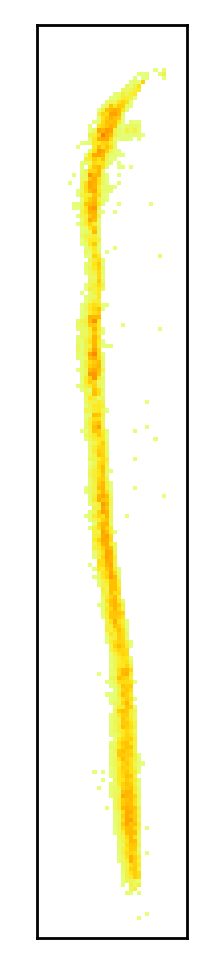

In [19]:
fig, ax = plt.subplots(dpi=250)

# plot img
ax.imshow(img, interpolation="nearest", cmap="Wistia")

y_lo = img.shape[0]
y_hi = 0
x_lo = img.shape[1]
x_hi = 0


# plot annotations
for color, (cls_label, annotation_lst) in zip(['tab:green', 'tab:red'], raster_dict.items()):
    print(f"{cls_label}: {color}")
    
    min_val = min(a.raster.min() for a in annotation_lst) 
    max_val = max(a.raster.max() for a in annotation_lst)
    
    cmap = LinearSegmentedColormap.from_list(color, [
        (min_val, "#0000"),
        (max_val, color),
    ])

    for annotation in annotation_lst:
        mask = template_transform.transform_template(annotation.raster)
        
        ys, xs = mask.nonzero()
        y_lo = min(y_lo, ys.min())
        y_hi = max(y_hi, ys.max())
        x_lo = min(x_lo, xs.min())
        x_hi = max(x_hi, xs.max())
        
        # ax.imshow(mask, alpha=0.8, cmap=cmap)


ax.set_xlim(left=x_lo-10, right=x_hi+10)
ax.set_ylim(bottom=y_hi+10, top=y_lo-10)
#ax.set_title(f"Annotated MSI: Region 13 {lipid}, LS/SC")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.tight_layout()

fig.savefig("region13_msi_LysoPPC.png")